In [1]:
!pip install extra-keras-datasets

In [2]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from extra_keras_datasets import emnist

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

INFO:root:Loading dataset = emnist


743907328/743900280 [==============================] - 38s 0us/step


label:  7


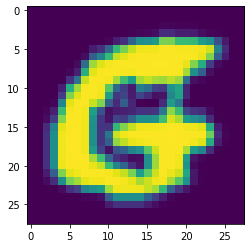

In [3]:
(train_images,train_labels),(test_images,test_labels) = emnist.load_data(type='letters')
plt.imshow(train_images[1])
print("label: ", train_labels[1])

**Creating Dataset for a Single Alphabet**

In [4]:
letter_G_images = []
for i in range(len(train_images)):
  if train_labels[i] == 7:
    letter_G_images.append(train_images[i])
train_images = np.array(letter_G_images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


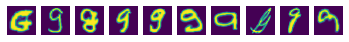

In [5]:
n = 10
f = plt.figure()
for i in range(n):
  f.add_subplot(1, n, i + 1)
  plt.subplot(1, n, i+1 ).axis("off")
  plt.imshow(train_images[i])
plt.show()

**Preparing Dataset**

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(32)

**Defining Generator Model**

In [7]:
gen_model = tf.keras.Sequential()

# Feed network with a 7x7 random image
gen_model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))

# Add batch normalization for stability
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())

# reshape the output
gen_model.add(tf.keras.layers.Reshape((7, 7, 256)))

# Apply (5x5) filter and shift of (1,1).
# The image output is still 7x7.
gen_model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())

# apply stride of (2,2). The output image is now 14x14.
gen_model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())

# another shift upscales the image to 28x28, whihch is our final size.
gen_model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

In [8]:
gen_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

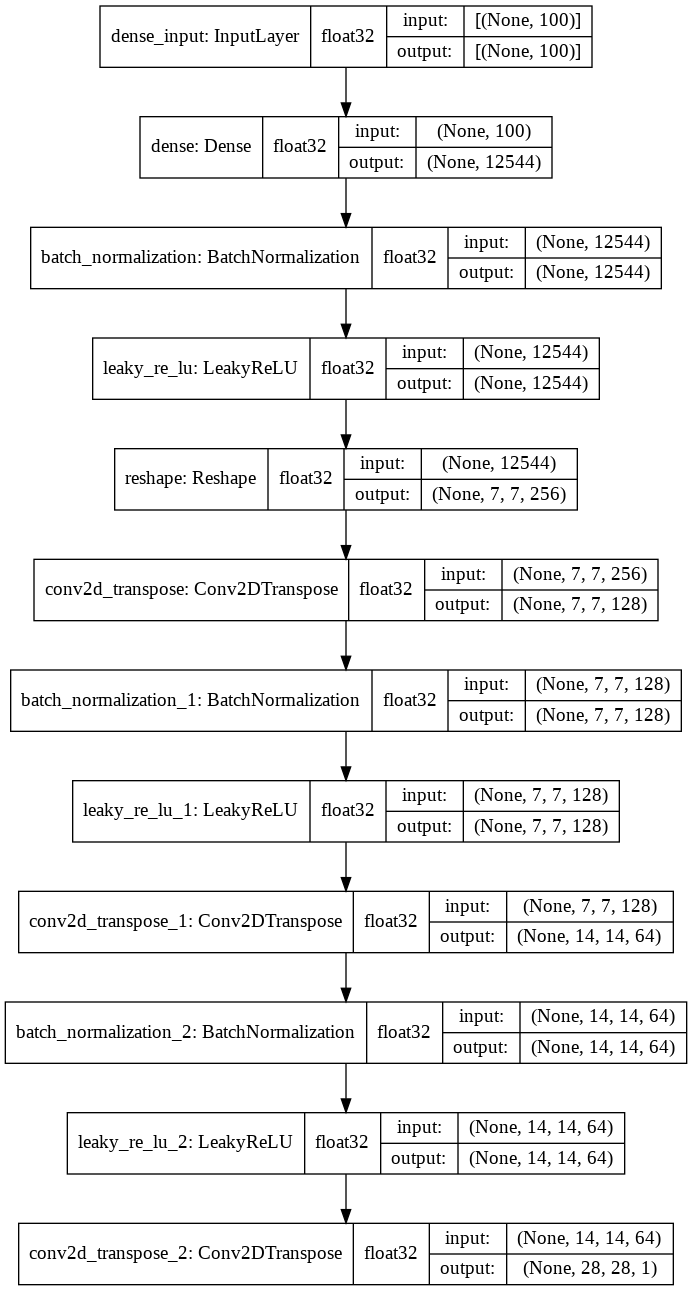

In [9]:
tf.keras.utils.plot_model(gen_model, 'generator.png', show_shapes=True, show_dtype=True, show_layer_names=True)

**Testing Generator**

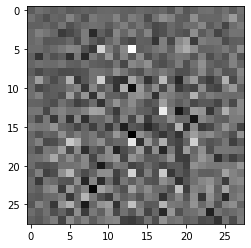

In [10]:
noise = tf.random.normal([1, 100])  #giving random input vector
generated_image = gen_model(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [11]:
generated_image.shape

TensorShape([1, 28, 28, 1])

**Defining Discriminator Model**

In [12]:
discri_model = tf.keras.Sequential()
discri_model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discri_model.add(tf.keras.layers.LeakyReLU())
discri_model.add(tf.keras.layers.Dropout(0.3))
discri_model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discri_model.add(tf.keras.layers.LeakyReLU())
discri_model.add(tf.keras.layers.Dropout(0.3))
discri_model.add(tf.keras.layers.Flatten())
discri_model.add(tf.keras.layers.Dense(1))

In [13]:
discri_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

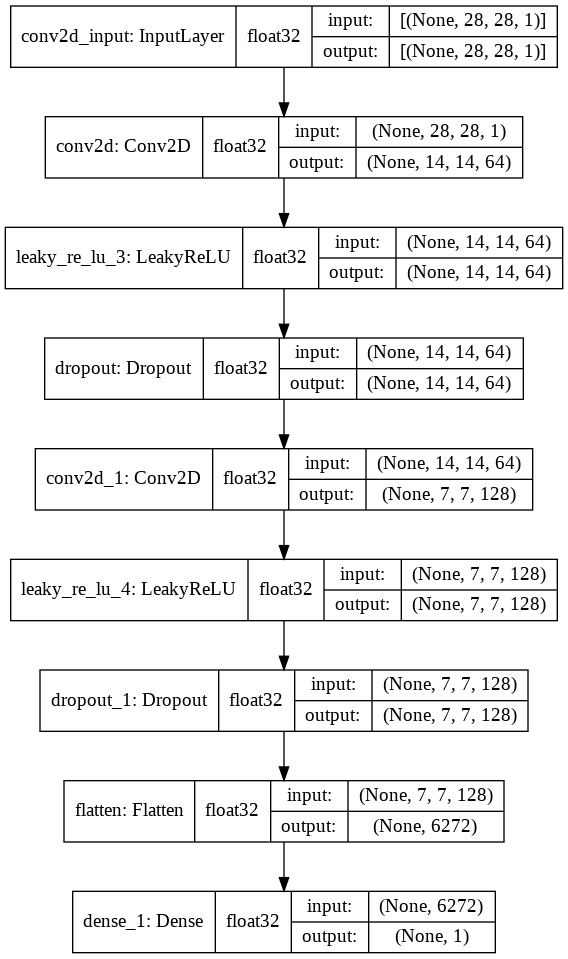

In [14]:
tf.keras.utils.plot_model(discri_model, 'discriminator.png', show_shapes=True, show_dtype=True, show_layer_names=True)

**Testing Discriminator**

In [15]:
decision = discri_model(generated_image)
print (decision)

tf.Tensor([[0.00121919]], shape=(1, 1), dtype=float32)


**Defining Loss Functions**

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
#creating loss function
def generator_loss(generated_output):
  return cross_entropy(tf.ones_like(generated_output), generated_output)

In [18]:
def discriminator_loss(real_output, generated_output):
  # compute loss considering the image is real [1,1,...,1]
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  
  # compute loss considering the image is fake[0,0,...,0]
  generated_loss = cross_entropy(tf.zeros_like(generated_output), generated_output)
  
  # compute total loss
  total_loss = real_loss + generated_loss
  
  return total_loss

**Optimisers**

In [19]:
gen_optimizer = tf.optimizers.Adam(1e-4)
discri_optimizer = tf.optimizers.Adam(1e-4)

**Defining Few Functions for Training**

In [20]:
epoch_number = 0
EPOCHS = 100
noise_dim = 100
seed = tf.random.normal([1, noise_dim])

**Checkpoint Setup**

In [21]:
checkpoint_dir = '/content/drive/MyDrive/Dataset/TensorFlow_GAN_CheckPoint_Output'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [22]:
checkpoint = tf.train.Checkpoint(
    generator_optimizer = gen_optimizer,
    discriminator_optimizer = discri_optimizer,
    generator = gen_model,
    discriminator = discri_model
)

**Model Training Step**

In [23]:
def gradient_tuning(images):
  # create a noise vector.
  noise = tf.random.normal([16, noise_dim])

  # Use gradient tapes for automatic differentiation
  with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
    # ask genertor to generate random images
    generated_images = gen_model(noise, training=True)

    # ask discriminator to evalute the real images and generate its output
    real_output = discri_model(images, training = True)
    
    # ask discriminator to do the evlaution on generated(fake) images
    fake_output = discri_model(generated_images, training = True)

    # calculate generator loss on fake data
    gen_loss = generator_loss(fake_output)

    # calculate discriminator loss as defined earlier
    disc_loss = discriminator_loss(real_output, fake_output)
  
    # calculate gradients for generator
    gen_gradients = generator_tape.gradient(gen_loss, gen_model.trainable_variables)

    # calculate gradients for discriminator
    discri_gradients = discriminator_tape.gradient(disc_loss, discri_model.trainable_variables)

    # use optimizer to process and apply gradients to variables
    gen_optimizer.apply_gradients(zip(gen_gradients, gen_model.trainable_variables))
    
    # same as above to discriminator
    discri_optimizer.apply_gradients(zip(discri_gradients, discri_model.trainable_variables))


In [24]:
def generate_and_save_images(model, epoch, test_input):
  global epoch_number
  epoch_number = epoch_number + 1

  # set training to false to ensure inference mode
  predictions = model(test_input, training = False)

  # display and save image
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:01d}.png'.format(epoch_number))
  plt.show()

**Model Training**

In [25]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      gradient_tuning(image_batch)

    # Produce images as we go
    generate_and_save_images(gen_model, epoch + 1, seed)

    # save checkpoint data
    checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format (epoch + 1, time.time()-start))

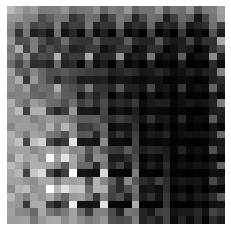

Time for epoch 1 is 9.458184242248535 sec


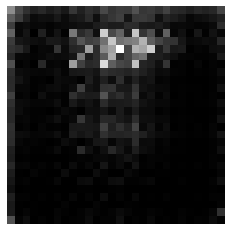

Time for epoch 2 is 9.08187747001648 sec


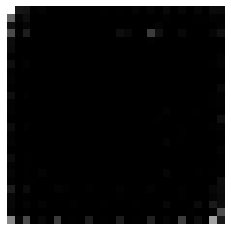

Time for epoch 3 is 8.887547254562378 sec


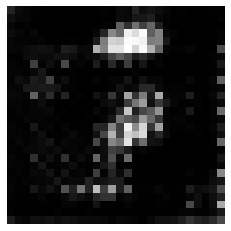

Time for epoch 4 is 8.903394222259521 sec


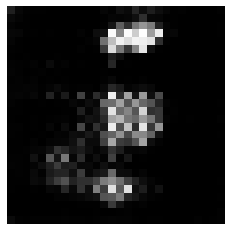

Time for epoch 5 is 8.977819442749023 sec


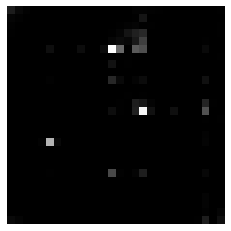

Time for epoch 6 is 9.005860328674316 sec


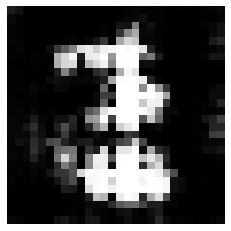

Time for epoch 7 is 8.840705871582031 sec


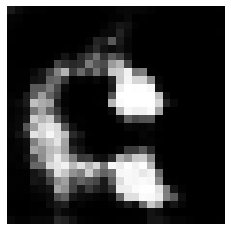

Time for epoch 8 is 8.931803703308105 sec


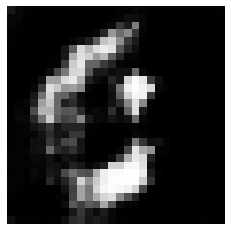

Time for epoch 9 is 8.930509805679321 sec


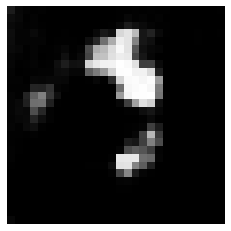

Time for epoch 10 is 9.03401494026184 sec


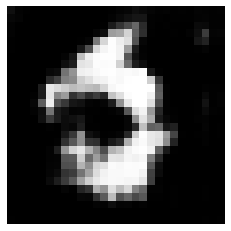

Time for epoch 11 is 9.003259181976318 sec


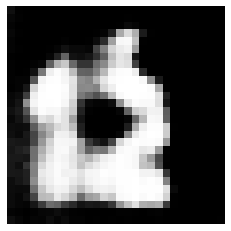

Time for epoch 12 is 8.863640785217285 sec


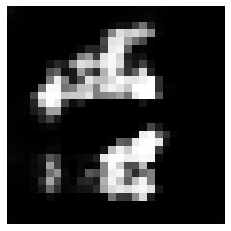

Time for epoch 13 is 8.83780813217163 sec


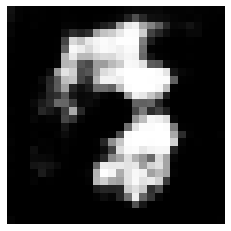

Time for epoch 14 is 8.920760869979858 sec


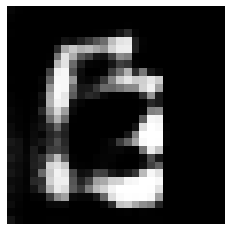

Time for epoch 15 is 8.932872295379639 sec


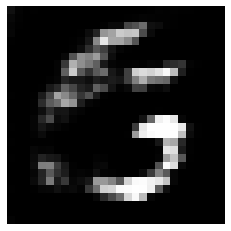

Time for epoch 16 is 8.903841257095337 sec


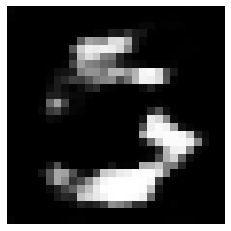

Time for epoch 17 is 8.9163076877594 sec


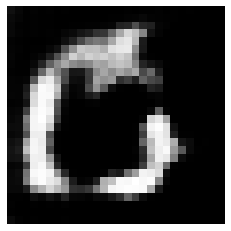

Time for epoch 18 is 8.925813913345337 sec


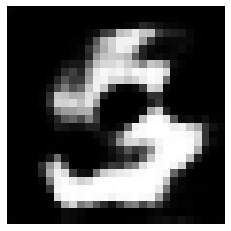

Time for epoch 19 is 8.874471664428711 sec


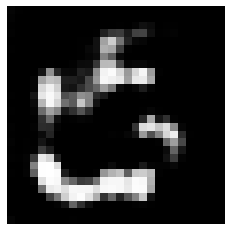

Time for epoch 20 is 8.915375471115112 sec


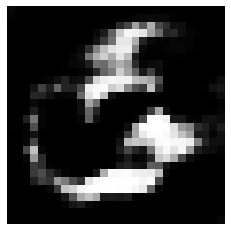

Time for epoch 21 is 8.847449541091919 sec


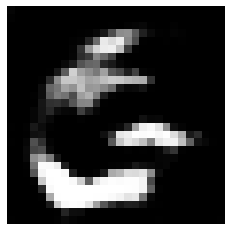

Time for epoch 22 is 8.990283489227295 sec


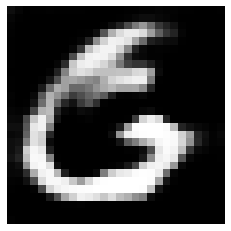

Time for epoch 23 is 8.97194528579712 sec


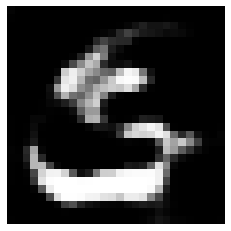

Time for epoch 24 is 9.02718997001648 sec


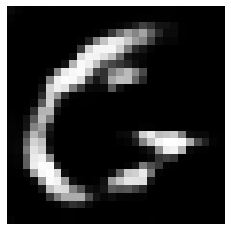

Time for epoch 25 is 8.975045680999756 sec


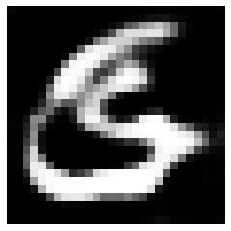

Time for epoch 26 is 8.843858003616333 sec


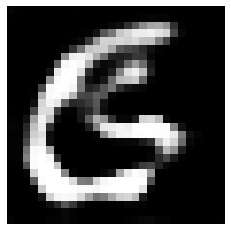

Time for epoch 27 is 8.76398229598999 sec


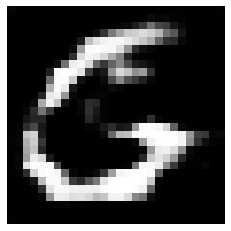

Time for epoch 28 is 8.841184616088867 sec


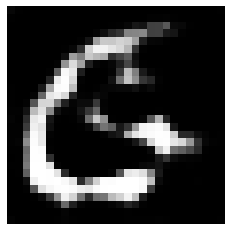

Time for epoch 29 is 8.875553846359253 sec


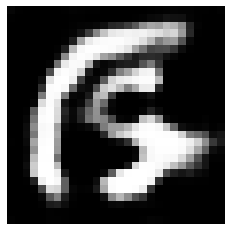

Time for epoch 30 is 8.98572301864624 sec


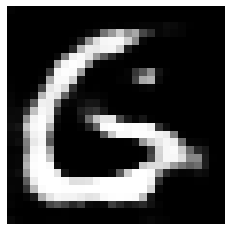

Time for epoch 31 is 9.060349702835083 sec


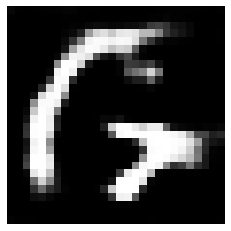

Time for epoch 32 is 8.987640857696533 sec


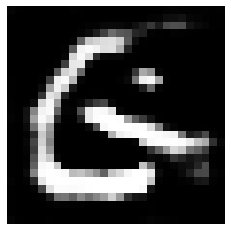

Time for epoch 33 is 8.87595534324646 sec


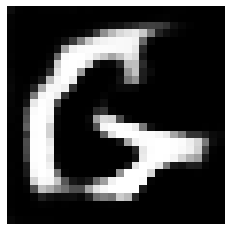

Time for epoch 34 is 8.914333581924438 sec


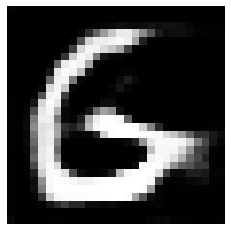

Time for epoch 35 is 9.111323595046997 sec


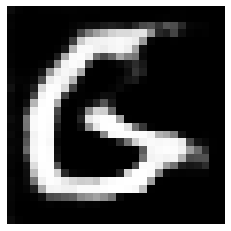

Time for epoch 36 is 9.052650213241577 sec


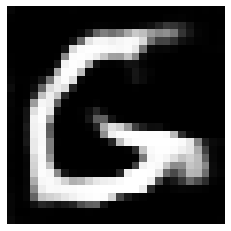

Time for epoch 37 is 9.315378665924072 sec


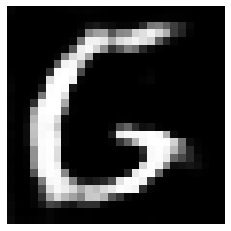

Time for epoch 38 is 9.231645345687866 sec


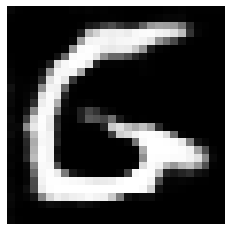

Time for epoch 39 is 9.20237684249878 sec


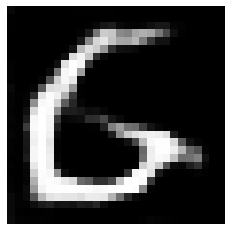

Time for epoch 40 is 9.263550519943237 sec


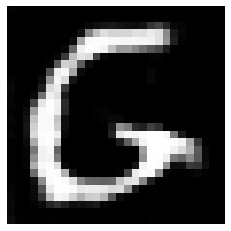

Time for epoch 41 is 9.26458477973938 sec


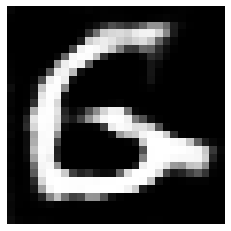

Time for epoch 42 is 9.266335725784302 sec


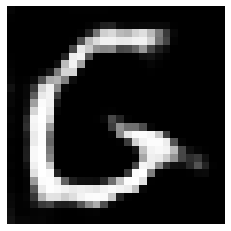

Time for epoch 43 is 9.032630205154419 sec


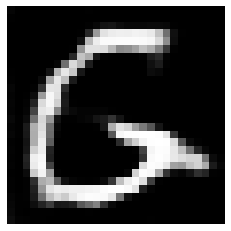

Time for epoch 44 is 9.052771091461182 sec


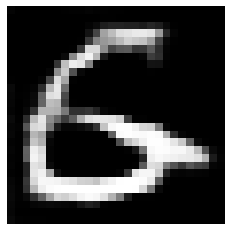

Time for epoch 45 is 9.009784698486328 sec


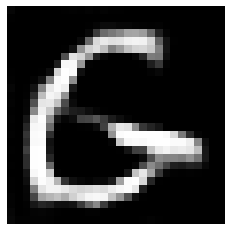

Time for epoch 46 is 9.006363868713379 sec


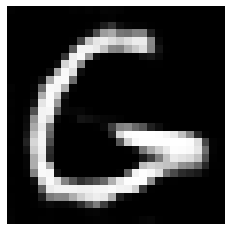

Time for epoch 47 is 8.896703004837036 sec


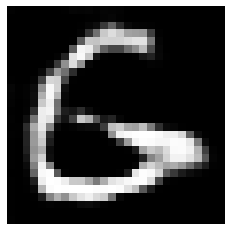

Time for epoch 48 is 9.015177965164185 sec


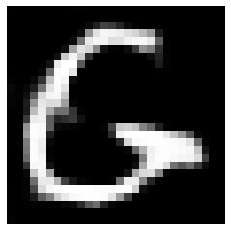

Time for epoch 49 is 8.797873258590698 sec


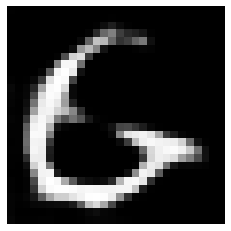

Time for epoch 50 is 8.98479700088501 sec


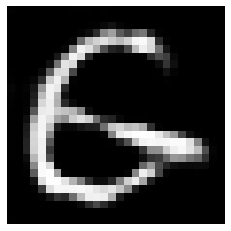

Time for epoch 51 is 9.039291381835938 sec


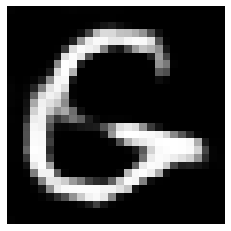

Time for epoch 52 is 8.931157112121582 sec


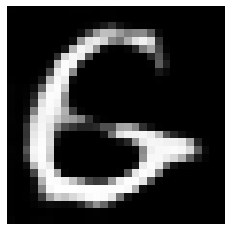

Time for epoch 53 is 8.957141876220703 sec


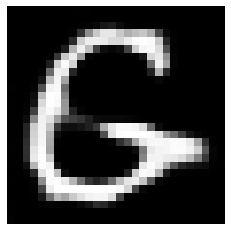

Time for epoch 54 is 10.419554233551025 sec


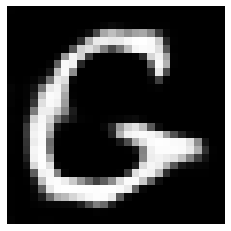

Time for epoch 55 is 8.9513840675354 sec


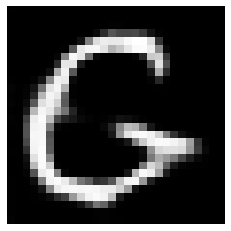

Time for epoch 56 is 8.962329864501953 sec


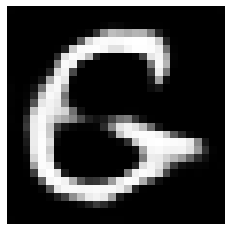

Time for epoch 57 is 8.985253810882568 sec


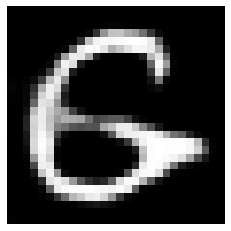

Time for epoch 58 is 8.98738694190979 sec


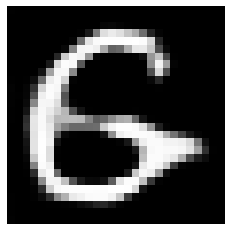

Time for epoch 59 is 8.960445880889893 sec


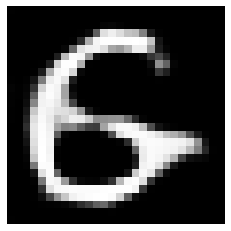

Time for epoch 60 is 8.950821161270142 sec


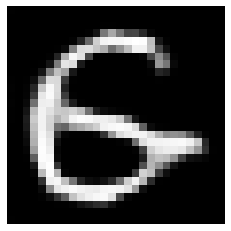

Time for epoch 61 is 9.015391111373901 sec


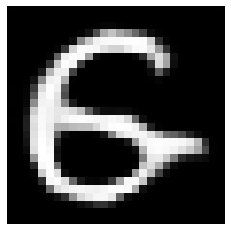

Time for epoch 62 is 8.930556058883667 sec


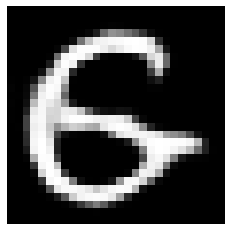

Time for epoch 63 is 8.984071254730225 sec


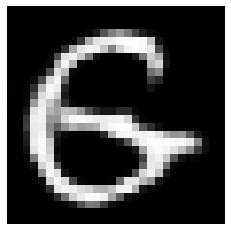

Time for epoch 64 is 8.988044500350952 sec


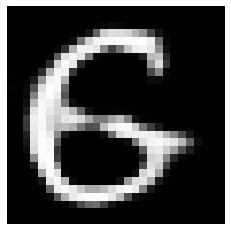

Time for epoch 65 is 9.037125825881958 sec


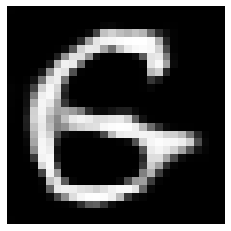

Time for epoch 66 is 9.017503023147583 sec


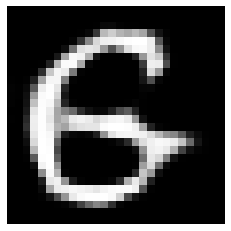

Time for epoch 67 is 8.922548055648804 sec


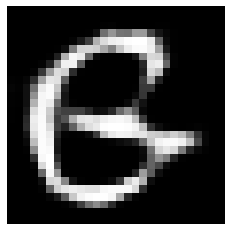

Time for epoch 68 is 9.196609020233154 sec


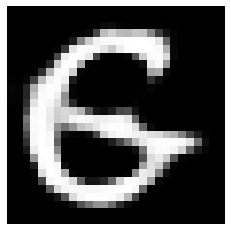

Time for epoch 69 is 8.996949672698975 sec


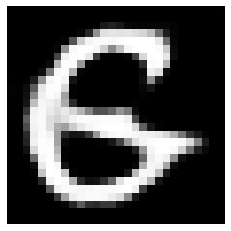

Time for epoch 70 is 9.032458782196045 sec


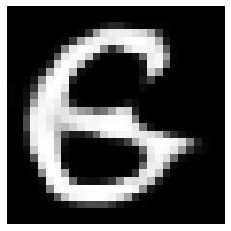

Time for epoch 71 is 9.008782863616943 sec


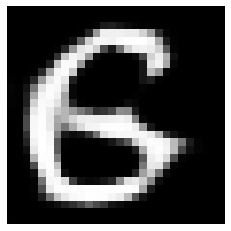

Time for epoch 72 is 9.000922918319702 sec


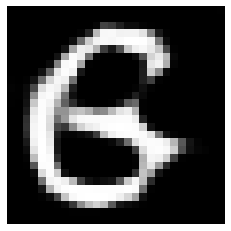

Time for epoch 73 is 9.110187292098999 sec


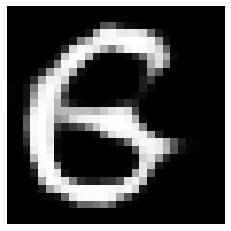

Time for epoch 74 is 8.89438533782959 sec


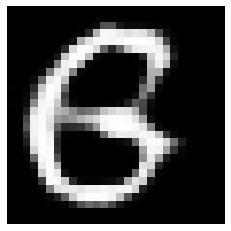

Time for epoch 75 is 8.969460248947144 sec


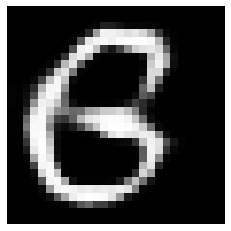

Time for epoch 76 is 9.020725965499878 sec


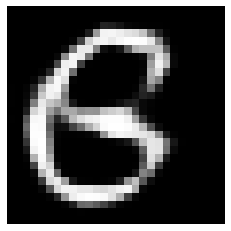

Time for epoch 77 is 9.054033994674683 sec


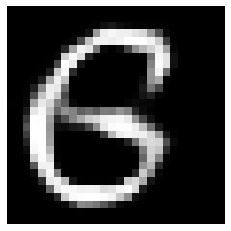

Time for epoch 78 is 8.983761072158813 sec


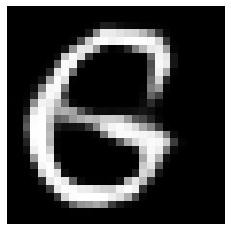

Time for epoch 79 is 9.058583736419678 sec


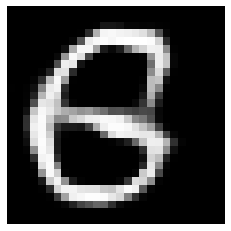

Time for epoch 80 is 9.003442287445068 sec


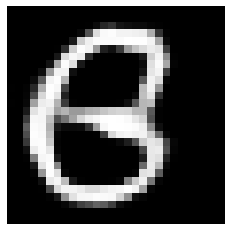

Time for epoch 81 is 9.090817213058472 sec


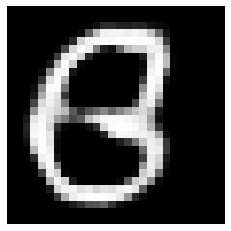

Time for epoch 82 is 9.009084939956665 sec


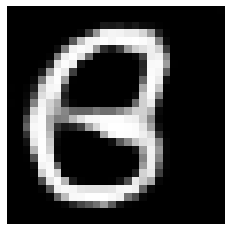

Time for epoch 83 is 9.092705249786377 sec


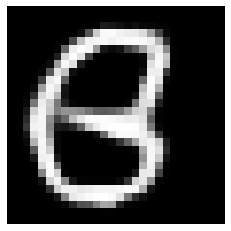

Time for epoch 84 is 8.999879598617554 sec


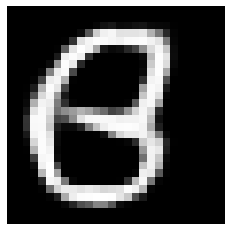

Time for epoch 85 is 9.002174854278564 sec


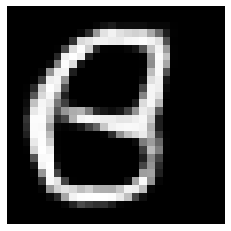

Time for epoch 86 is 8.983122825622559 sec


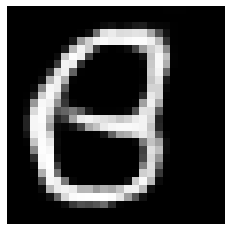

Time for epoch 87 is 8.977435827255249 sec


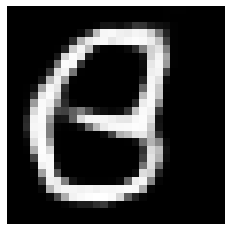

Time for epoch 88 is 8.929353952407837 sec


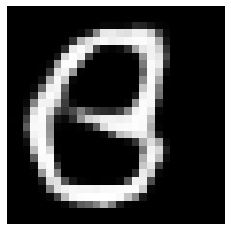

Time for epoch 89 is 8.990058898925781 sec


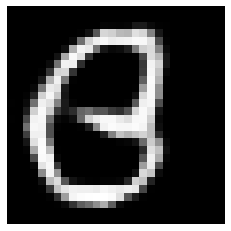

Time for epoch 90 is 8.91837477684021 sec


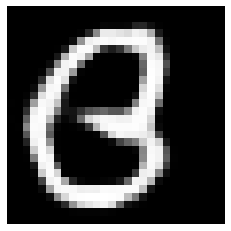

Time for epoch 91 is 9.003660678863525 sec


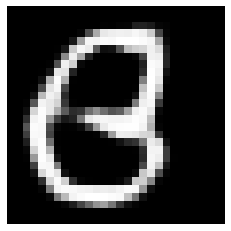

Time for epoch 92 is 8.935480833053589 sec


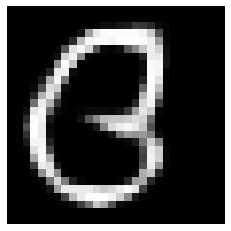

Time for epoch 93 is 8.926985502243042 sec


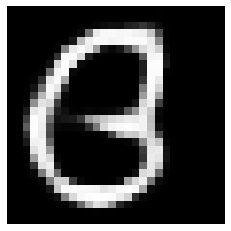

Time for epoch 94 is 8.965930461883545 sec


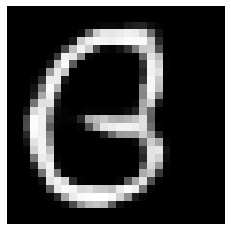

Time for epoch 95 is 9.009103775024414 sec


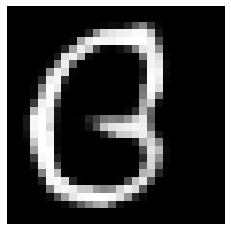

Time for epoch 96 is 8.965561151504517 sec


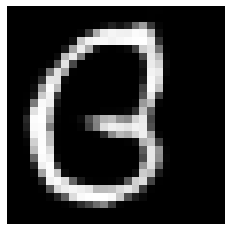

Time for epoch 97 is 8.999700546264648 sec


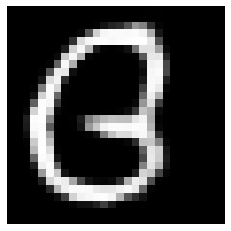

Time for epoch 98 is 8.939339876174927 sec


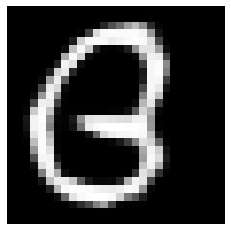

Time for epoch 99 is 9.079572439193726 sec


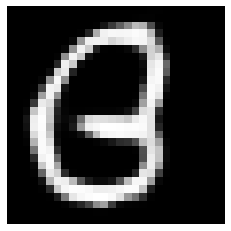

Time for epoch 100 is 8.98060917854309 sec


In [26]:
train(train_dataset, EPOCHS)

During training and in case of disconnection, you can restore the network state from a previous known checkpoint as shown in the statement here and continue the training.

In [ ]:
#run this code only if there is a runtime disconnection
try:
  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
except Exception as error:
  print("Error loading in model :{}".format(error))

train(train_dataset, EPOCHS)